### Verificando o efeito do desdobramento de features. Nesse notebook o desdobramento de features SIM é feito.

A comparação pode ser feita com o notebook exploring 3

In [1]:
import preprocessing.read as r
import preprocessing.st_ops as ops
import preprocessing.feature_ops as feat
import visualization.builders as vis

import torch

from torch_geometric.data import Data
from torch_geometric.data import Batch

import matplotlib
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation

from IPython.display import HTML
from IPython.display import display

import numpy as np
from scipy.spatial.transform import Rotation as R

from pythreejs import *

from math import pi

from sklearn.model_selection import KFold

# FUNÇÕES

## FUNÇÃO DE ANIMAÇÃO

In [59]:
def animate_function(i, action, edges, node_html_colors):
    colors = [[1,0,0],[0,0.5,0],[0,0.8,0.8],[0.8,0.8,0],[0,0,1]]
    ax.clear()
    ax.axis([-1.5, 1.5, -1.5 ,1.5])
    frame = action[i]
    axis_x = frame[:,0]
    axis_y = frame[:,1]
    for edge_index in range(edges.shape[1]):        
        s_x = axis_x[edges[0,edge_index]]
        s_y = axis_y[edges[0,edge_index]]
        t_x = axis_x[edges[1,edge_index]]
        t_y = axis_y[edges[1,edge_index]]
        line = plt.Line2D((s_x,t_x), (s_y,t_y))
        ax.add_artist(line)
    for node_index in range(len(axis_x)):
        node_color = matplotlib.colors.to_rgb(node_html_colors[node_index])
        circle = plt.Circle((axis_x[node_index], axis_y[node_index]), .05, color=node_color)
        ax.add_artist(circle)
        ax.annotate(node_index, xy=(axis_x[node_index], axis_y[node_index]))

## NORMALIZAÇÃO DOS DADOS

In [3]:
def normalize_data(athletes):
    for athlete in athletes:

        min_y = float("inf")
        max_y = -float("inf")
        min_x = float("inf")
        max_x = -float("inf")
        min_z = float("inf")
        max_z = -float("inf")

        for _, activity in athlete.activities.items():
            for sample in activity:
                min_x = min(min_x, sample[:,:,0].min())
                max_x = max(max_x, sample[:,:,0].max())
                min_y = min(min_y, sample[:,:,1].min())
                max_y = max(max_y, sample[:,:,1].max())
                min_z = min(min_z, sample[:,:,2].min())
                max_z = max(max_z, sample[:,:,2].max())
            
        scale = (max_y - min_y)/2  # A mesma escala será usada nas 3 dimensões para preservar proporção
        move_x = -(min_x + max_x)/2
        move_y = -(min_y + max_y)/2
        move_z = -(min_z + max_z)/2

        for _, activity in athlete.activities.items():
            for sample in activity:
                sample[:,:,0] = (sample[:,:,0] + move_x)/scale
                sample[:,:,1] = (sample[:,:,1] + move_y)/scale
                sample[:,:,2] = (sample[:,:,2] + move_z)/scale

## DATA AUGMENTATION

In [4]:
def data_augmentation(athletes, rotate=True, noise=True):  
    n_athletes = len(athletes)
    
    for base_idx in range(n_athletes):
        angle = np.random.randint(50) - 25
        base_athlete = athletes[base_idx]
        
        for label, base_activity in base_athlete.activities.items():
            base_sample = base_activity[0] ## Original sample
            if rotate:
                base_sample = feat.rotate(base_sample, angle)
            if noise:
                base_sample = feat.apply_noise(base_sample, 0.1)
            athletes[base_idx].add(label, base_sample)

## DEFINIÇÃO DO MODELO

In [5]:
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, ChebConv, SAGEConv
from torch_scatter import scatter_mean

class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = SAGEConv(48, 8)
        self.conv2 = SAGEConv(8, 8)
        self.conv3 = SAGEConv(8, 8)
        self.conv4 = SAGEConv(8, 7)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index) 
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv3(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv4(x, edge_index)
        x = F.relu(x)
        return F.softmax(x)

## CRIAÇÃO DE SEQUENCIAS E BATCHES

In [30]:
from IPython.display import clear_output, display

def create_activity_sequence(athlete, act_idx):
    sequence_frames = []
    sequence_labels = []

    # Build graph
    for label, _ in athlete.activities.items():
        frames = athlete.get(label, act_idx)
        sequence_frames.append(frames)

    sequence_frames = np.concatenate( sequence_frames )
    sequence_st_data, sequence_st_edges = ops.create_st_graph(unfold_features(sequence_frames), edges, 16)



    # Build labels
    for label, _ in athlete.activities.items():
        frames = athlete.get(label, act_idx)
        total_nodes = frames.shape[0]*frames.shape[1]
        sequence_labels.append(np.ones(total_nodes) * label_idx[label])

    sequence_labels = np.concatenate( sequence_labels )
    # sequence_labels = indices_to_one_hot(sequence_labels, 7)
    
    data = Data(
                x=torch.tensor(sequence_st_data, dtype=torch.float), 
                edge_index=torch.tensor(sequence_st_edges, dtype=torch.long), 
                y=torch.tensor(sequence_labels, dtype=torch.long)
                )
    
    return data

def create_batch(train_athletes, val_athletes):
    n_samples = len(train_athletes[0].activities['Back Kick'])
    
    train_list = []
    validation_list = []
    
    for act_idx in range(n_samples):
        
        train_seq = [create_activity_sequence(train_athlete, act_idx) for train_athlete in train_athletes]
        validation_seq = [create_activity_sequence(val_athlete, act_idx) for val_athlete in val_athletes]
        
        train_list.extend(train_seq)
        validation_list.extend(validation_seq)

    train_batch = Batch.from_data_list(train_list)
    validation_batch = Batch.from_data_list(validation_list)

    return train_batch, validation_batch

## FUNÇÃO DE TREINAMENTO

In [52]:
def train(train_batch, validation_batch, epochs=100, device=torch.device('cuda')):
    
    model = Net().to(device)
    train_data = train_batch.to(device)
    validation_data = validation_batch.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.002)
    model.train()
    acc_history_val = []
    acc_history_train = []
    epoch_history = []
    for epoch in range(epochs):
        optimizer.zero_grad()
        out = model(train_data)
        # print(out.shape)
        # print(out[0])
        # loss = F.nll_loss(out, data.y)
        loss = F.cross_entropy(out, train_data.y)
        loss.backward()
        optimizer.step()
        total_loss = loss.item()
        if (epoch + 1) % 100 == 0:
            model.eval()
            
            _, pred = model(validation_data).max(dim=1)
            correct = float (pred.eq(validation_data.y).sum().item())
            acc_val = correct / float(validation_data.y.shape[0])

            _, pred = model(train_data).max(dim=1)
            correct = float (pred.eq(train_data.y).sum().item())
            acc_train = correct / float(train_data.y.shape[0])

            acc_history_val.append(acc_val)
            acc_history_train.append(acc_train)
            epoch_history.append(epoch)
            clear_output(wait=True)

            print('[{}/{}] Loss: {:.4f} / Acc_val: {:.4f} / Acc_train: {:.4f}'.format(epoch, epochs, total_loss, acc_val, acc_train))
            
            model.train()
            
    return epoch_history, acc_history_val, acc_history_train  

## FUNÇÕES AUXILIARES

In [8]:
def unfold_features(data):
    num_frames = data.shape[0]
    num_nodes = data.shape[1]
    num_dim = data.shape[2]
    res = np.zeros((num_frames, num_nodes, num_nodes*num_dim))
    for frame_idx in range(num_frames):
        for node_idx in range(num_nodes):
            res[frame_idx, node_idx, num_dim*node_idx:num_dim*(node_idx+1)] = data[frame_idx,node_idx]
    return res

def indices_to_one_hot(data, num_classes):
    """Convert an iterable of indices to one-hot encoded labels."""
    targets = data.reshape(-1).astype(int)
    return np.eye(num_classes)[targets]

# EXECUÇÃO

# Lendo dataset

In [ ]:
loader = r.TaekwondoLoader('../dataset')
athletes, labels, label_idx = loader.load()

In [65]:
athletes[0].get('Back Kick', 0)

array([[[-262.731964,  293.560059, 2668.121582],
        [ -16.163462,  244.943848, 2735.909668],
        [-105.628372,  469.698547, 2737.811279],
        ...,
        [-473.743225, -910.322388, 2616.136963],
        [  24.978374, -925.219727, 2631.661621],
        [-139.447723,  269.251953, 2702.015625]],

       [[-272.552063,  289.919769, 2659.922852],
        [ -32.785275,  241.811035, 2747.636719],
        [-121.413437,  466.979858, 2739.739502],
        ...,
        [-457.935333, -901.594421, 2602.686768],
        [  34.372414, -918.063721, 2627.918701],
        [-152.668671,  265.865417, 2703.779785]],

       [[-286.526306,  290.429016, 2657.418701],
        [ -49.532715,  241.462631, 2753.202881],
        [-139.996414,  466.29895 , 2748.134766],
        ...,
        [-465.384979, -899.373108, 2601.100098],
        [  24.271812, -903.253784, 2611.606689],
        [-168.029495,  265.945831, 2705.310791]],

       ...,

       [[-420.715149,  316.58197 , 2614.381592],
        [-1

# Normalizando as features

Aqui estou normalizando as features espaciais. O observador atento perceberá que uso o mesmo fator de escala para todas as dimensões e centralizando as coordenadas em torno da origem. Por preservar as proporções, isso me permitirá gerar pequenas rotações no atleta com maior facilidade.

Também estou escalando por atleta, numa tentativa de normalizar os dados em relação a altura dos atletas. Isso posteriormente pode ser revertido ao fazer data augmentation.

In [66]:
print(athletes[0].get('Back Kick')[0, :, :])
normalize_data(athletes)
print("NORMALIZED DATA: ")
print(athletes[0].get('Back Kick')[0, :, :])

[[-262.731964  293.560059 2668.121582]
 [ -16.163462  244.943848 2735.909668]
 [-105.628372  469.698547 2737.811279]
 [-170.320801   64.891304 2667.748291]
 [-110.006447 -157.448898 2658.550781]
 [-292.381317 -121.489807 2608.411133]
 [   0.          0.          0.      ]
 [-262.731323   19.326324 2668.121582]
 [  58.041443    8.270645 2787.517578]
 [-263.123871 -254.906403 2667.475098]
 [ 195.561874 -141.554062 2609.847656]
 [-363.564575 -534.083496 2619.784912]
 [ -58.074657 -572.039429 2632.944824]
 [-473.743225 -910.322388 2616.136963]
 [  24.978374 -925.219727 2631.661621]
 [-139.447723  269.251953 2702.015625]]
NORMALIZED DATA: 
[[-0.15279017  0.698985    1.53822257]
 [ 0.16380543  0.63656146  1.62526292]
 [ 0.04893189  0.92514799  1.62770461]
 [-0.03413362  0.4053728   1.53774326]
 [ 0.04331041  0.1198865   1.5259336 ]
 [-0.19086014  0.16605821  1.46155396]
 [ 0.18455942  0.32205193 -1.88766329]
 [-0.15278935  0.34686706  1.53822257]
 [ 0.25908502  0.3326715   1.69152782]
 [-0.1

## Data augmentation

In [ ]:
print(f"Quantidade de movimenos por classe: {len(athletes[0].activities['Back Kick'])}")
data_augmentation(athletes)
print(f"Quantidade de movimenos por classe: {len(athletes[0].activities['Back Kick'])}")

In [73]:
athletes[0].get('Back Kick', 3)

array([[[ 0.54711852,  0.71223074,  1.42798038],
        [ 0.97586418,  0.6703474 ,  1.36462759],
        [ 0.80088226,  0.90810886,  1.284866  ],
        ...,
        [ 0.07702632, -0.85631571,  1.56631472],
        [ 0.71716022, -0.89621484,  1.31235478],
        [ 0.72144408,  0.74552878,  1.50770002]],

       [[ 0.604154  ,  0.58183478,  1.64697798],
        [ 0.76985126,  0.55532362,  1.61256872],
        [ 0.66646632,  1.02521929,  1.63428973],
        ...,
        [ 0.1292778 , -0.64255144,  1.46674789],
        [ 0.77008978, -0.89379288,  1.25642389],
        [ 0.69676436,  0.79887484,  1.37896664]],

       [[ 0.27079512,  0.73415322,  1.61139227],
        [ 0.77060274,  0.7850721 ,  1.54071051],
        [ 0.61196833,  0.89972236,  1.42481593],
        ...,
        [ 0.1110404 , -0.88351651,  1.53840801],
        [ 0.68090302, -0.70502856,  1.37678095],
        [ 0.48539718,  0.63393938,  1.42239116]],

       ...,

       [[ 0.28068127,  0.77325927,  1.56050439],
        [ 0

In [ ]:
adj_list = {
    0: [3, 7, 15, 6],
    1: [3, 8, 15, 6],
    2: [15, 6],
    3: [0, 1, 4, 5, 15, 6],
    4: [3, 5, 12, 6],
    5: [3, 4, 11, 6],
    6: [0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15],
    7: [0, 9, 6],
    8: [1, 10, 6],
    9: [7, 6],
    10: [8, 6],
    11: [5, 13, 6],
    12: [4, 14, 6],
    13: [11, 6],
    14: [12, 6],
    15: [0, 1, 2, 3, 6]
}

edges = ops.adjlist_to_coo(adj_list)

In [80]:
for train_idxs, test_idxs in tqdm(kf.split(athletes), desc="Training model..."):
    
    train_athletes = [athletes[idx] for idx in train_idxs]
    test_athletes = [athletes[idx] for idx in test_idxs]
    
    print(train_athletes)
    print(test_athletes)

Training model...: 5it [00:00, 2229.12it/s]

[<preprocessing.read.TaekwondoAthlete object at 0x7f548c7a65d0>, <preprocessing.read.TaekwondoAthlete object at 0x7f548ff61210>, <preprocessing.read.TaekwondoAthlete object at 0x7f54a41f7a50>, <preprocessing.read.TaekwondoAthlete object at 0x7f54a4514990>, <preprocessing.read.TaekwondoAthlete object at 0x7f548fe14150>, <preprocessing.read.TaekwondoAthlete object at 0x7f548fe14b90>, <preprocessing.read.TaekwondoAthlete object at 0x7f548fe14a50>, <preprocessing.read.TaekwondoAthlete object at 0x7f548fe14ed0>]
[<preprocessing.read.TaekwondoAthlete object at 0x7f548fe01f50>, <preprocessing.read.TaekwondoAthlete object at 0x7f548fe14290>]
[<preprocessing.read.TaekwondoAthlete object at 0x7f548fe01f50>, <preprocessing.read.TaekwondoAthlete object at 0x7f548ff61210>, <preprocessing.read.TaekwondoAthlete object at 0x7f54a41f7a50>, <preprocessing.read.TaekwondoAthlete object at 0x7f54a4514990>, <preprocessing.read.TaekwondoAthlete object at 0x7f548fe14b90>, <preprocessing.read.TaekwondoAthlete 

## Train model (CV)

In [81]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
kf.get_n_splits(athletes)

epochs = 200

from tqdm import tqdm

folds_history = []
acc_val_hist = []
acc_train_hist = []

for train_idxs, test_idxs in tqdm(kf.split(athletes), desc="Training model..."):
    
    train_athletes = [athletes[idx] for idx in train_idxs]
    test_athletes = [athletes[idx] for idx in test_idxs]
    
    train_batch, test_batch = create_batch(train_athletes, test_athletes)

    fold_history, fold_acc_val, fold_acc_train = train(train_batch, test_batch, epochs, device=torch.device('cuda'))
    
    folds_history.append(fold_history)
    acc_val_hist.append(fold_acc_val)
    acc_train_hist.append(fold_acc_train)

Training model...: 5it [00:21,  4.34s/it]

[199/200] Loss: 1.8890 / Acc_val: 0.2807 / Acc_train: 0.2622


In [85]:
acc_val_hist

[[0.17584181201550386, 0.22644137596899225],
 [0.1956781914893617, 0.24298537234042553],
 [0.1787709497206704, 0.24435521415270017],
 [0.15280135823429541, 0.27368951612903225],
 [0.13478535353535354, 0.2806712962962963]]

# Matriz de adjacências do esqueleto

![title](skeleton_model.png)

In [33]:
adj_list = {
    0: [3, 7, 15, 6],
    1: [3, 8, 15, 6],
    2: [15, 6],
    3: [0, 1, 4, 5, 15, 6],
    4: [3, 5, 12, 6],
    5: [3, 4, 11, 6],
    6: [0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15],
    7: [0, 9, 6],
    8: [1, 10, 6],
    9: [7, 6],
    10: [8, 6],
    11: [5, 13, 6],
    12: [4, 14, 6],
    13: [11, 6],
    14: [12, 6],
    15: [0, 1, 2, 3, 6]
}

In [9]:
if false:
    adj_list = {
        0: [3, 7, 19],
        1: [3, 8, 19],
        2: [19],
        3: [0, 1, 4, 5, 19],
        4: [3, 5, 14],
        5: [3, 4, 13],
        7: [0, 9],
        8: [1, 10],
        9: [7],
        10: [8],
        13: [5, 15],
        14: [4, 16],
        15: [13],
        16: [14],
        19: [0, 1, 2, 3]
    }

In [60]:
node_html_colors = { 
    0: '#FFFF00',
    1: '#02FF00',
    2: '#666666',
    3: '#FF00FF',
    4: '#02FF00',
    5: '#FFFF00',
    6: '#666666',
    7: '#FF9802',
    8: '#02FFFF',
    9: '#FF0000',
    10: '#0600FF',
    11: '#000000',
    12: '#000000',
    13: '#FF9802',
    14: '#02FFFF',
    15: '#FF0000',
    16: '#0600FF',
    17: '#000000',
    18: '#000000',
    19: '#FF00FF'
}

In [ ]:
edges = ops.adjlist_to_coo(adj_list)

edge_index = torch.tensor(edges, dtype=torch.long)
x = torch.tensor(frame, dtype=torch.float)

data = Data(x=x, edge_index=edge_index)
print(data)

In [57]:
activity = athletes[0].get('Back Kick', 0)
activity.shape

(43, 16, 3)

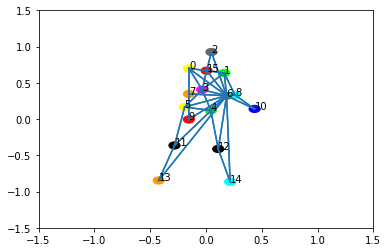

In [61]:
fig = plt.figure()
ax = plt.axes()
activity = athletes[0].get('Back Kick', 0)
ani = matplotlib.animation.FuncAnimation(fig, 
                                         animate_function, 
                                         fargs=(activity, edges, node_html_colors), 
                                         frames=len(activity))
HTML(ani.to_jshtml()) 

In [24]:
ani.save('../animation.gif', writer='imagemagick', fps=5)

# Unindo grafos de uma atividade

In [27]:
st_data, st_edges = ops.create_st_graph(unfold_features(frames), edges, 20)


print(st_data.shape)
print(st_edges.shape)

(704, 48)
(2, 4536)


In [28]:
st_data_vis, st_edges_vis = ops.create_st_graph(frames[5:15], edges, 16)
agrb = vis.ActivityGraphRendererBuilder(16, frame_spacing=1, node_scale=.05, node_colors=node_html_colors)
agrb.add_data(st_data_vis[:,0:2], st_edges_vis)
display(agrb.build_renderer())

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.5, position=(3.0, 5.0,…

# Unindo atividades para criar uma sequência

## Aqui estou desmembrando as features

# Criando dados de entrada para a rede

# Criando a GCN

In [40]:
torch.save(model, '../model/taekwondo_activity_segmentation_exp2.pth')

/home/danilo/anaconda3/envs/pygeo/lib/python3.7/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [41]:
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())


Model's state_dict:
conv1.weight 	 torch.Size([48, 8])
conv1.bias 	 torch.Size([8])
conv2.weight 	 torch.Size([8, 8])
conv2.bias 	 torch.Size([8])
conv3.weight 	 torch.Size([8, 8])
conv3.bias 	 torch.Size([8])
conv4.weight 	 torch.Size([8, 7])
conv4.bias 	 torch.Size([7])


# Testando um caso

In [42]:
test_athlete = 1
test_data = validation_data.to_data_list()[test_athlete]
_, pred = model(test_data).max(dim=1)
pred_cpu = pred.cpu().numpy()
label_cpu = test_data.y.cpu().numpy()
result = pred_cpu==label_cpu
print('Accuracy: {}'.format(result.sum()/pred_cpu.shape[0]))

Accuracy: 0.29854166666666665


/home/danilo/anaconda3/envs/pygeo/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [43]:
label_colors = {
    0: matplotlib.colors.to_rgb('#c62bc6'),
    1: matplotlib.colors.to_rgb('#49bcad'),
    2: matplotlib.colors.to_rgb('#e1ff00'),
    3: matplotlib.colors.to_rgb('#00bbff'),
    4: matplotlib.colors.to_rgb('#ffd800'),
    5: matplotlib.colors.to_rgb('#00ff11'),
    6: matplotlib.colors.to_rgb('#001dff'),
    7: matplotlib.colors.to_rgb('#fff600'),
    8: matplotlib.colors.to_rgb('#d65968'),
}

{'Left Kick To The Head', 'Left Kick', 'Right Kick', 'Right Punch', 'Back Kick', 'Right Kick To The Head', 'Left Punch'}


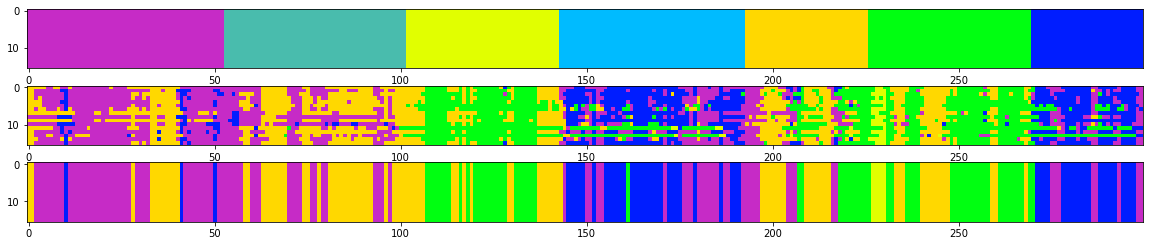

In [47]:
from scipy import stats

ground_truth = label_cpu.flatten()
colored_labels = np.array([ label_colors[i] for i in label_cpu.flatten()])
colored_labels = colored_labels.reshape((-1,16, 3))

colored_preds = np.array([ label_colors[i] for i in pred_cpu.flatten()])
colored_preds = colored_preds.reshape((-1,16, 3))

frame_wise_mode = stats.mode(pred_cpu.reshape((-1,16)), axis=1)
frame_pred = frame_wise_mode[0]
colored_frame_pred = np.array([ [label_colors[i] for j in range(16)]  for i in frame_pred.flatten()])

print(labels)
fig=plt.figure(figsize=(20, 4))
fig.add_subplot(3, 1, 1)
plt.imshow(np.transpose(colored_labels, (1,0,2)))
fig.add_subplot(3, 1, 2)
plt.imshow(np.transpose(colored_preds, (1,0,2)))
fig.add_subplot(3, 1, 3)
plt.imshow(np.transpose(colored_frame_pred, (1,0,2)))

plt.show()

In [65]:
ground_truth = label_cpu.reshape((-1,16))[:,0]
final_pred = frame_pred.flatten()
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support
cm = confusion_matrix(ground_truth, final_pred) 

[[39.  0.  0.  0. 11.  0.  3.]
 [20.  0.  0.  0. 29.  0.  0.]
 [ 0.  0.  0.  0. 17. 24.  0.]
 [18.  0.  0.  0.  1.  1. 30.]
 [ 9.  0.  0.  0. 14. 10.  0.]
 [ 0.  0.  4.  0. 14. 26.  0.]
 [ 8.  0.  0.  0.  0.  1. 21.]]


[[39  0  0  0 11  0  3]
 [20  0  0  0 29  0  0]
 [ 0  0  0  0 17 24  0]
 [18  0  0  0  1  1 30]
 [ 9  0  0  0 14 10  0]
 [ 0  0  4  0 14 26  0]
 [ 8  0  0  0  0  1 21]]


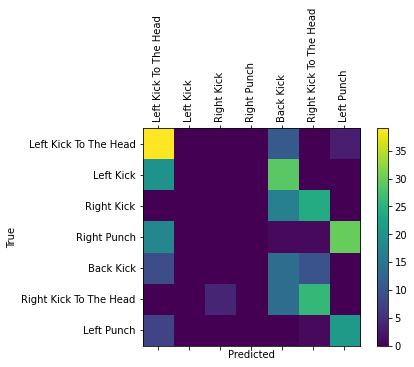

In [77]:
print(cm)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
# plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
plt.xticks(rotation='vertical')
ax.set_xticklabels([''] + list(labels))
ax.set_yticklabels([''] + list(labels))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [68]:
cm

array([[39,  0,  0,  0, 11,  0,  3],
       [20,  0,  0,  0, 29,  0,  0],
       [ 0,  0,  0,  0, 17, 24,  0],
       [18,  0,  0,  0,  1,  1, 30],
       [ 9,  0,  0,  0, 14, 10,  0],
       [ 0,  0,  4,  0, 14, 26,  0],
       [ 8,  0,  0,  0,  0,  1, 21]])